In [14]:
import pandas as pd
import json 
import os 
import sys
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

path = 'data/llama2_7b'
sns.set(style="whitegrid")

In [15]:
import json 
def gcg_results(path): 
    res = []
    with open(os.path.join(path)) as f:
        for line in f:
            res.append(json.loads(line))

    monitor_losses = []
    gcg_losses = []
    early_stop = []
    for r in res:
        monitor_losses.append(r['monitor_losses'])
        gcg_losses.append(r['gcg_losses'])
        early_stop.append(np.any(r['early_stopping']))

    monitor_losses = np.array(monitor_losses)
    gcg_losses = np.array(gcg_losses)
    early_stop = np.array(early_stop)
    res = {
        'monitor_losses': monitor_losses,
        'gcg_losses': gcg_losses,
        'early_stop': early_stop
    }
    return res

def log_prob_results(path): 
    res = []
    with open(os.path.join(path)) as f:
        for line in f:
            res.append(json.loads(line))
            
    monitor_losses = []
    log_probs = []
    score = []
    best_scores = []
    
    for r in res:
        monitor_losses.append(r['monitor_loss'])
        log_probs.append(r['logprob'])
        score.append(r['score'])
        best_scores.append(r['best_scores'])
    
    monitor_losses = np.array(monitor_losses)
    log_probs = np.array(log_probs)
    score = np.array(score)
    best_scores = np.array(best_scores)
    
    res = {
        'monitor_losses': monitor_losses,
        'log_probs': log_probs,
        'score': score,
        'best_scores': best_scores
    }
    return res

def std_err(data): 
    return np.std(data) / np.sqrt(len(data))

### Probe layer sweep

In [16]:
just_hb_8 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr8.json'))
just_hb_16 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr16.json'))
just_hb_24 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr24.json'))
just_hb_30 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr30.json'))

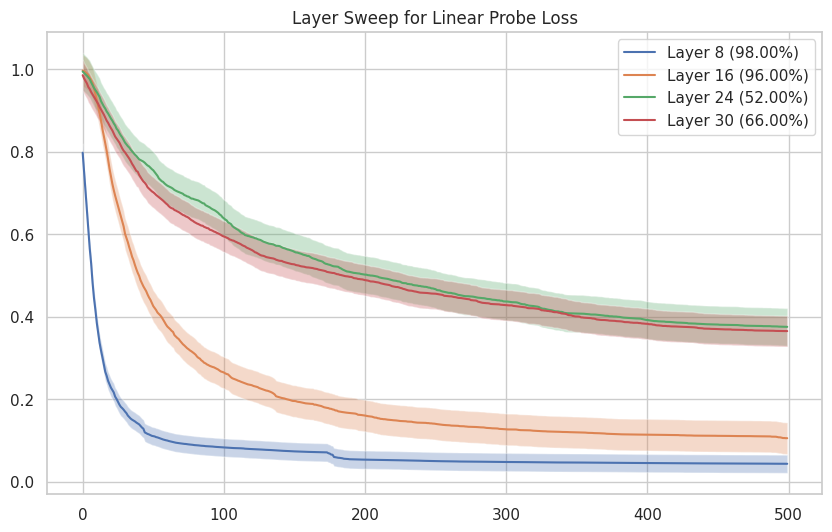

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(data=just_hb_8['monitor_losses'].mean(0), ax=ax, label=f'Layer 8 ({just_hb_8["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_8['monitor_losses'].mean(0) - std_err(just_hb_8['monitor_losses']), just_hb_8['monitor_losses'].mean(0) + std_err(just_hb_8['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_16['monitor_losses'].mean(0), ax=ax, label=f'Layer 16 ({just_hb_16["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_16['monitor_losses'].mean(0) - std_err(just_hb_16['monitor_losses']), just_hb_16['monitor_losses'].mean(0) + std_err(just_hb_16['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_24['monitor_losses'].mean(0), ax=ax, label=f'Layer 24 ({just_hb_24["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_24['monitor_losses'].mean(0) - std_err(just_hb_24['monitor_losses']), just_hb_24['monitor_losses'].mean(0) + std_err(just_hb_24['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_30['monitor_losses'].mean(0), ax=ax, label=f'Layer 30 ({just_hb_30["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_30['monitor_losses'].mean(0) - std_err(just_hb_30['monitor_losses']), just_hb_30['monitor_losses'].mean(0) + std_err(just_hb_30['monitor_losses']), alpha=0.3)
plt.title('Layer Sweep for Linear Probe Loss')
plt.show()


### GCG against just the monitor

In [5]:
just_ft_hb_alpaca = gcg_results(os.path.join(path, 'actual_final_gcg_just_ft_llamaguard_harmbench_alpaca_.json'))
just_hb_alpaca_lyr24 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr24.json'))

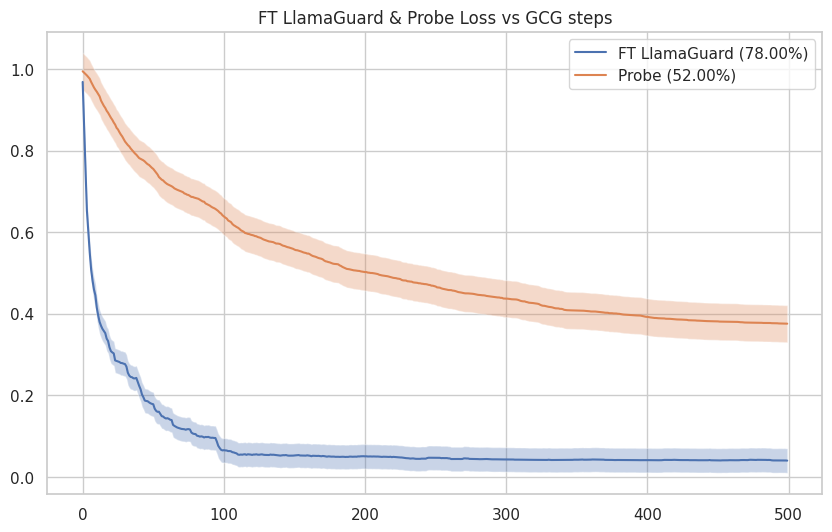

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(data=just_ft_hb_alpaca['monitor_losses'].mean(0), ax=ax, label=f'FT LlamaGuard ({just_ft_hb_alpaca["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_ft_hb_alpaca['monitor_losses'].mean(0) - std_err(just_ft_hb_alpaca['monitor_losses']), just_ft_hb_alpaca['monitor_losses'].mean(0) + std_err(just_ft_hb_alpaca['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_alpaca_lyr24['monitor_losses'].mean(0), ax=ax, label=f'Probe ({just_hb_alpaca_lyr24["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_alpaca_lyr24['monitor_losses'].mean(0) - std_err(just_hb_alpaca_lyr24['monitor_losses']), just_hb_alpaca_lyr24['monitor_losses'].mean(0) + std_err(just_hb_alpaca_lyr24['monitor_losses']), alpha=0.3)
plt.title('FT LlamaGuard & Probe Loss vs GCG steps')
plt.show()

### GCG against both

In [8]:
ft_hb_alpaca = gcg_results(os.path.join(path, 'actual_final_gcg_ft_llamaguard_harmbench_alpaca_.json'))
hb_alpaca_lyr24 = gcg_results(os.path.join(path, 'actual_final_gcg_hb_lyr24.json'))

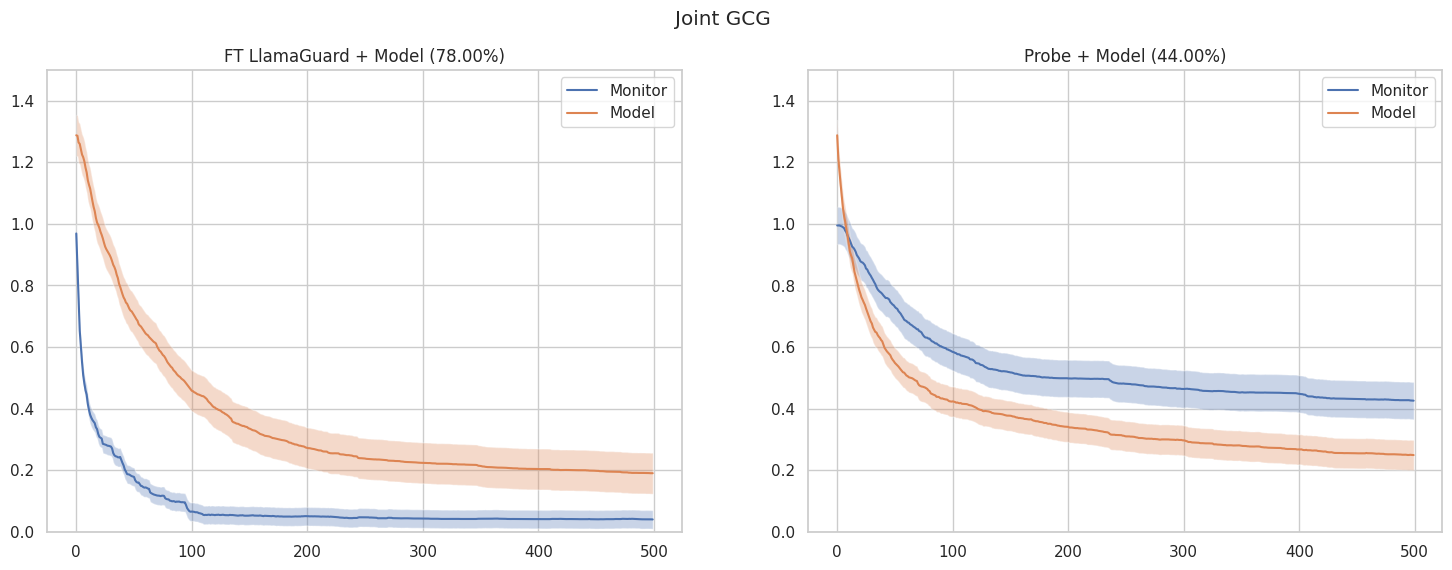

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=ft_hb_alpaca['monitor_losses'].mean(0), ax=axs[0], label='Monitor')
axs[0].fill_between(np.arange(500), ft_hb_alpaca['monitor_losses'].mean(0) - std_err(ft_hb_alpaca['monitor_losses']), ft_hb_alpaca['monitor_losses'].mean(0) + std_err(ft_hb_alpaca['monitor_losses']), alpha=0.3)
sns.lineplot(data=ft_hb_alpaca['gcg_losses'].mean(0), ax=axs[0], label='Model')
axs[0].fill_between(np.arange(500), ft_hb_alpaca['gcg_losses'].mean(0) - std_err(ft_hb_alpaca['gcg_losses']), ft_hb_alpaca['gcg_losses'].mean(0) + std_err(ft_hb_alpaca['gcg_losses']), alpha=0.3)
axs[0].title.set_text(f'FT LlamaGuard + Model ({ft_hb_alpaca["early_stop"].mean() * 100:.2f}%)')
axs[0].set_ylim(0, 1.5)

sns.lineplot(data=hb_alpaca_lyr24['monitor_losses'].mean(0), ax=axs[1], label='Monitor')
axs[1].fill_between(np.arange(500), hb_alpaca_lyr24['monitor_losses'].mean(0) - std_err(hb_alpaca_lyr24['monitor_losses']), hb_alpaca_lyr24['monitor_losses'].mean(0) + std_err(hb_alpaca_lyr24['monitor_losses']), alpha=0.3)
sns.lineplot(data=hb_alpaca_lyr24['gcg_losses'].mean(0), ax=axs[1], label='Model')
axs[1].fill_between(np.arange(500), hb_alpaca_lyr24['gcg_losses'].mean(0) - std_err(hb_alpaca_lyr24['gcg_losses']), hb_alpaca_lyr24['gcg_losses'].mean(0) + std_err(hb_alpaca_lyr24['gcg_losses']), alpha=0.3)
axs[1].title.set_text(f'Probe + Model ({hb_alpaca_lyr24["early_stop"].mean() * 100:.2f}%)')
axs[1].set_ylim(0, 1.5)

plt.suptitle('Joint GCG')
plt.show()

### GCG against just the monitor (MLP)

In [30]:
just_ft_hb_alpaca = gcg_results(os.path.join(path, 'actual_final_gcg_just_ft_llamaguard_harmbench_alpaca_.json'))
just_hb_alpaca_lyr24 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr24_mlp.json'))

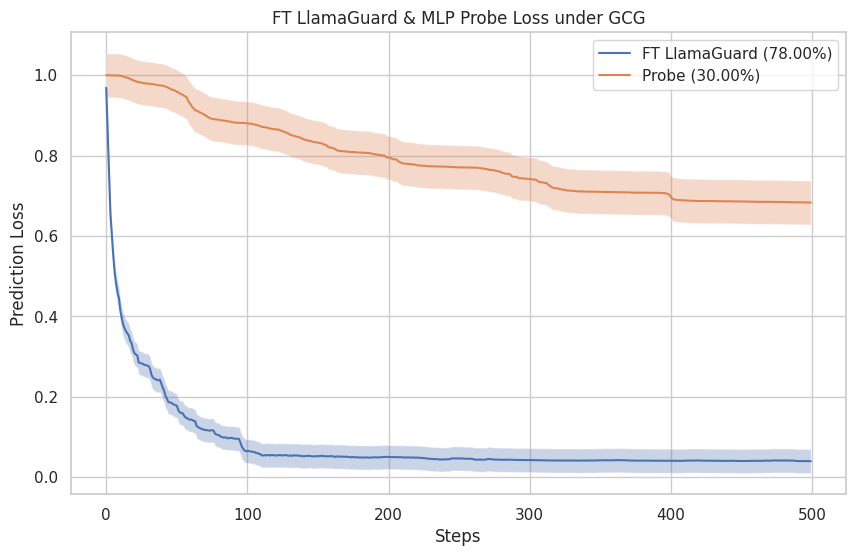

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(data=just_ft_hb_alpaca['monitor_losses'].mean(0), ax=ax, label=f'FT LlamaGuard ({just_ft_hb_alpaca["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_ft_hb_alpaca['monitor_losses'].mean(0) - std_err(just_ft_hb_alpaca['monitor_losses']), just_ft_hb_alpaca['monitor_losses'].mean(0) + std_err(just_ft_hb_alpaca['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_alpaca_lyr24['monitor_losses'].mean(0), ax=ax, label=f'Probe ({just_hb_alpaca_lyr24["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_alpaca_lyr24['monitor_losses'].mean(0) - std_err(just_hb_alpaca_lyr24['monitor_losses']), just_hb_alpaca_lyr24['monitor_losses'].mean(0) + std_err(just_hb_alpaca_lyr24['monitor_losses']), alpha=0.3)
plt.title('FT LlamaGuard & MLP Probe Loss under GCG')
ax.set_ylabel('Prediction Loss')
ax.set_xlabel('Steps')
plt.show()

In [32]:
# # save as svg
# plt.savefig('plots/gcg_just_ft_llamaguard_and_mlp_probe.svg')

### GCG against both (MLP)

In [33]:
ft_hb_alpaca = gcg_results(os.path.join(path, 'actual_final_gcg_ft_llamaguard_harmbench_alpaca_.json'))
hb_alpaca_lyr24 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr24_mlp.json'))

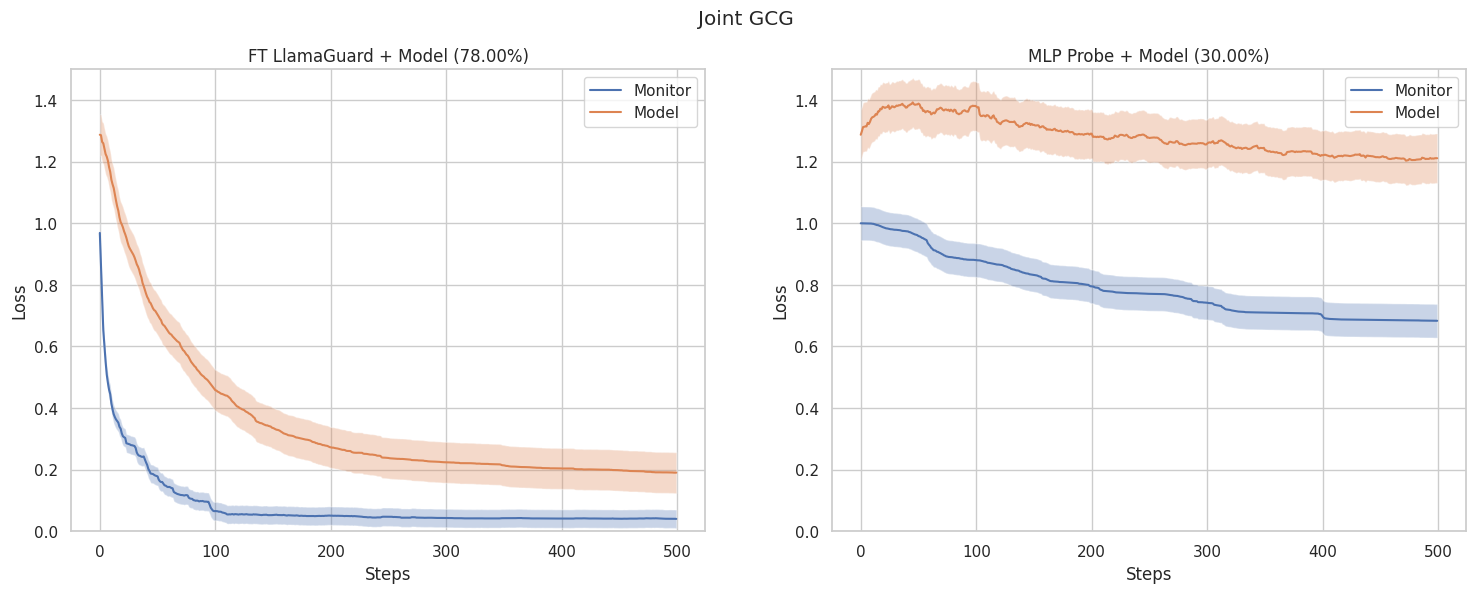

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=ft_hb_alpaca['monitor_losses'].mean(0), ax=axs[0], label='Monitor')
axs[0].fill_between(np.arange(500), ft_hb_alpaca['monitor_losses'].mean(0) - std_err(ft_hb_alpaca['monitor_losses']), ft_hb_alpaca['monitor_losses'].mean(0) + std_err(ft_hb_alpaca['monitor_losses']), alpha=0.3)
sns.lineplot(data=ft_hb_alpaca['gcg_losses'].mean(0), ax=axs[0], label='Model')
axs[0].fill_between(np.arange(500), ft_hb_alpaca['gcg_losses'].mean(0) - std_err(ft_hb_alpaca['gcg_losses']), ft_hb_alpaca['gcg_losses'].mean(0) + std_err(ft_hb_alpaca['gcg_losses']), alpha=0.3)
axs[0].title.set_text(f'FT LlamaGuard + Model ({ft_hb_alpaca["early_stop"].mean() * 100:.2f}%)')
axs[0].set_ylim(0, 1.5)
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Steps')

sns.lineplot(data=hb_alpaca_lyr24['monitor_losses'].mean(0), ax=axs[1], label='Monitor')
axs[1].fill_between(np.arange(500), hb_alpaca_lyr24['monitor_losses'].mean(0) - std_err(hb_alpaca_lyr24['monitor_losses']), hb_alpaca_lyr24['monitor_losses'].mean(0) + std_err(hb_alpaca_lyr24['monitor_losses']), alpha=0.3)
sns.lineplot(data=hb_alpaca_lyr24['gcg_losses'].mean(0), ax=axs[1], label='Model')
axs[1].fill_between(np.arange(500), hb_alpaca_lyr24['gcg_losses'].mean(0) - std_err(hb_alpaca_lyr24['gcg_losses']), hb_alpaca_lyr24['gcg_losses'].mean(0) + std_err(hb_alpaca_lyr24['gcg_losses']), alpha=0.3)
axs[1].title.set_text(f'MLP Probe + Model ({hb_alpaca_lyr24["early_stop"].mean() * 100:.2f}%)')
axs[1].set_ylim(0, 1.5)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Steps')

plt.suptitle('Joint GCG')
plt.show()

### Probe ablations

In [11]:
just_hb_alpaca_lyr24_new_hparam = gcg_results(os.path.join(path, 'actual_final_gcg_hb_lyr24_new_hparam.json'))
just_hb_alpaca_lyr24_mlp = gcg_results(os.path.join(path, 'actual_final_gcg_hb_lyr24_mlp.json'))
just_hb_alpaca_lyr24 = gcg_results(os.path.join(path, 'actual_final_gcg_hb_lyr24.json'))

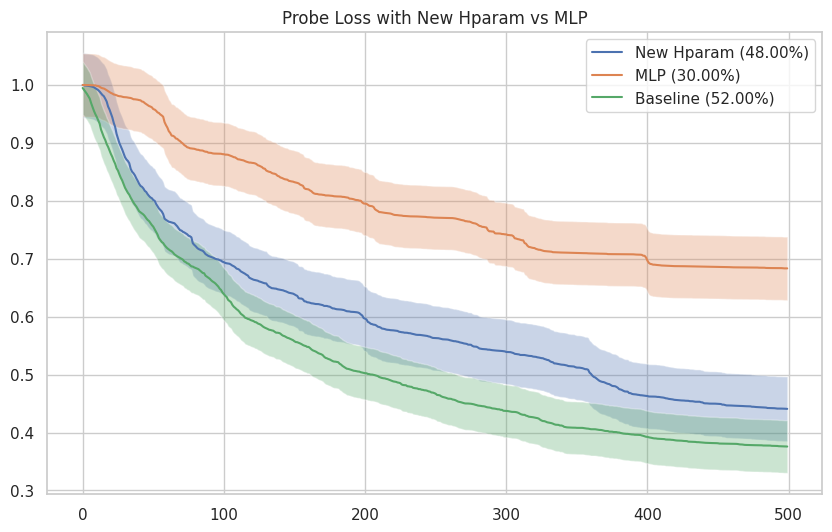

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(data=just_hb_alpaca_lyr24_new_hparam['monitor_losses'].mean(0), ax=ax, label=f'New Hparam ({just_hb_alpaca_lyr24_new_hparam["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_alpaca_lyr24_new_hparam['monitor_losses'].mean(0) - std_err(just_hb_alpaca_lyr24_new_hparam['monitor_losses']), just_hb_alpaca_lyr24_new_hparam['monitor_losses'].mean(0) + std_err(just_hb_alpaca_lyr24_new_hparam['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_alpaca_lyr24_mlp['monitor_losses'].mean(0), ax=ax, label=f'MLP ({just_hb_alpaca_lyr24_mlp["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_alpaca_lyr24_mlp['monitor_losses'].mean(0) - std_err(just_hb_alpaca_lyr24_mlp['monitor_losses']), just_hb_alpaca_lyr24_mlp['monitor_losses'].mean(0) + std_err(just_hb_alpaca_lyr24_mlp['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_alpaca_lyr24['monitor_losses'].mean(0), ax=ax, label=f'Baseline ({just_hb_alpaca_lyr24["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_alpaca_lyr24['monitor_losses'].mean(0) - std_err(just_hb_alpaca_lyr24['monitor_losses']), just_hb_alpaca_lyr24['monitor_losses'].mean(0) + std_err(just_hb_alpaca_lyr24['monitor_losses']), alpha=0.3)

plt.title('Probe Loss with New Hparam vs MLP')
plt.show()


### Log prob

In [12]:
just_ft_hb_alpaca = log_prob_results(os.path.join(path, 'log_prob_just_ft_llamaguard_hb_alpaca.json'))


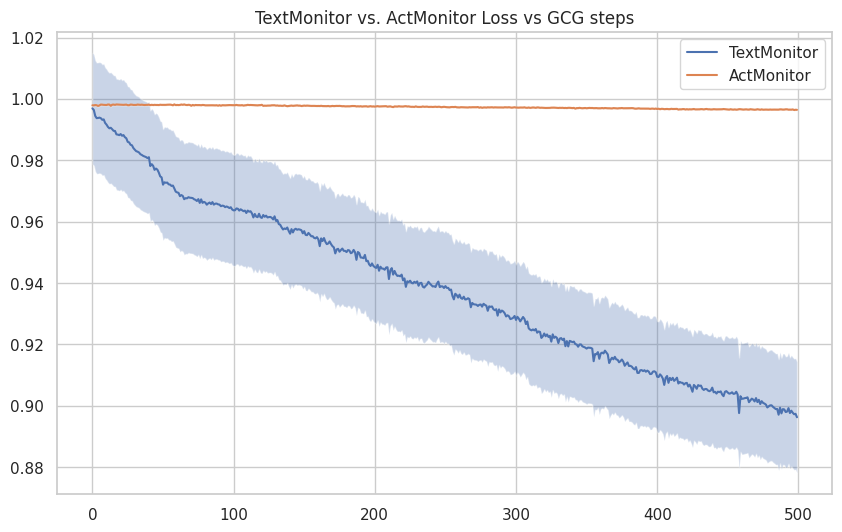

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(data=just_ft_hb_alpaca['monitor_losses'].mean(0), ax=ax, label=f'TextMonitor')
plt.fill_between(np.arange(500), just_ft_hb_alpaca['monitor_losses'].mean(0) - std_err(just_ft_hb_alpaca['monitor_losses']), just_ft_hb_alpaca['monitor_losses'].mean(0) + std_err(just_ft_hb_alpaca['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_alpaca_lyr24['monitor_losses'].mean(0), ax=ax, label=f'ActMonitor')
plt.fill_between(np.arange(500), just_hb_alpaca_lyr24['monitor_losses'].mean(0) - std_err(just_hb_alpaca_lyr24['monitor_losses']), just_hb_alpaca_lyr24['monitor_losses'].mean(0) + std_err(just_hb_alpaca_lyr24['monitor_losses']), alpha=0.3)
plt.title('TextMonitor vs. ActMonitor Loss vs GCG steps')
plt.show()